# Dataset Analysis and 3D Visualization

This notebook loads simulation data from `.vtu` files for multiple samples, combining randomized Young’s modulus scalar fields `E` and Von Mises stress scalar fields `vm` into a unified DataFrame.  

It includes steps for exploratory data analysis, data cleaning, feature scaling, and interactive 3D visualization using **PyVista**.  

The notebook inspects distributions, validate data integrity, and explore spatial patterns across the samples.


## Setup

In [6]:

import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Configuration
DATA_DIR = Path('../data/DataSet1000/data/')
N_SAMPLES = 10
E_FIELD_NAME = 'E'
VM_FIELD_NAME = 'sigma_vm'

## Data Loading Functions

In [7]:
def load_sample(i, data_dir=DATA_DIR):
    """Load E and sigma_vm meshes for sample i."""
    e_file = data_dir / f"rand_E{i}_p0_000000.vtu"
    vm_file = data_dir / f"vm{i}_p0_000000.vtu"
    if not e_file.exists() or not vm_file.exists():
        print(f"[WARN] Missing files for sample {i}")
        return None, None
    e_mesh = pv.read(str(e_file))
    vm_mesh = pv.read(str(vm_file))
    if e_mesh.n_points != vm_mesh.n_points:
        raise ValueError(f"Mismatch in points: E({e_mesh.n_points}) vs vm({vm_mesh.n_points})")
    return e_mesh, vm_mesh

In [8]:
def load_all_samples(n_samples=N_SAMPLES):
    """Load all samples and return (samples, E_list, vm_list, mesh_ref)."""
    samples, E_list, vm_list = [], [], []
    mesh_ref = None
    for i in range(1, n_samples+1):
        e_mesh, vm_mesh = load_sample(i)
        if e_mesh is None: 
            continue
        if mesh_ref is None:
            mesh_ref = e_mesh.copy()
        E_list.append(np.array(e_mesh.point_data[E_FIELD_NAME]))
        vm_list.append(np.array(vm_mesh.point_data[VM_FIELD_NAME]))
        samples.append(i)
    print(f"[INFO] Loaded {len(samples)} samples. Nodes per sample: {E_list[0].shape[0] if E_list else None}")
    return samples, E_list, vm_list, mesh_ref


samples, E_list, vm_list, mesh_ref = load_all_samples()

[INFO] Loaded 10 samples. Nodes per sample: 10502


## Building DataFrame

In [9]:
coords = mesh_ref.points
rows = []

for sample_id, (E, vm) in zip(samples, zip(E_list, vm_list)):
    E = E.reshape(-1, E.shape[-1]) if E.ndim == 2 else E.reshape(-1, 1)
    for node_id in range(coords.shape[0]):
        row = {
            'sample_id': sample_id,
            'node_id': node_id,
            'x': coords[node_id, 0],
            'y': coords[node_id, 1],
            'z': coords[node_id, 2],
            'sigma_vm': float(vm[node_id])
        }
        for j in range(E.shape[1]):
            row[f'E_{j}'] = float(E[node_id, j])
        rows.append(row)

df = pd.DataFrame(rows)
print(df.head(), "\nShape:", df.shape)

   sample_id  node_id         x         y        z   sigma_vm        E_0
0          1        0 -0.529040  1.461507  0.20000   6.663795  17.316418
1          1        1 -0.550000  1.500000  0.20000   7.362384  17.316418
2          1        2 -0.500000  1.500000  0.20000   7.187914  17.316418
3          1        3 -0.524116  1.500000  0.15852  13.049497  32.062276
4          1        4 -0.565216  1.465253  0.20000   6.455465  17.316418 
Shape: (105020, 7)


## Exploratory Data Analysis

### Distribution of sigma_vm

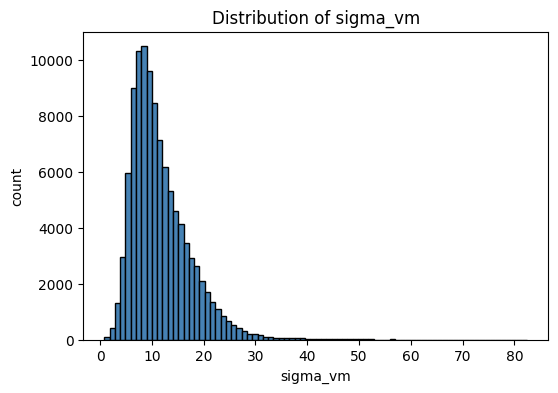

In [10]:
plt.figure(figsize=(6,4))
plt.hist(df['sigma_vm'], bins=80, color='steelblue', edgecolor='black')
plt.title('Distribution of sigma_vm')
plt.xlabel('sigma_vm'); plt.ylabel('count')
plt.show()

## Sample-wise statistics

In [11]:
sample_stats = df.groupby('sample_id')['sigma_vm'].describe()
display(sample_stats[['mean','50%','std']])

,mean,50%,std
sample_id,,,
1,11.290098,9.821022,5.704772
2,11.892448,10.469270,6.117764
3,11.787187,10.464472,5.644041
4,11.856511,10.638557,5.516031
5,11.192337,9.872426,5.553231
6,11.603377,10.169206,5.711099
7,10.807961,9.882573,4.767378
8,11.254567,10.094100,5.380405
9,11.945523,10.816147,5.449039


## Visualize first sample on mesh

D:\ml_stress_model\venv\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


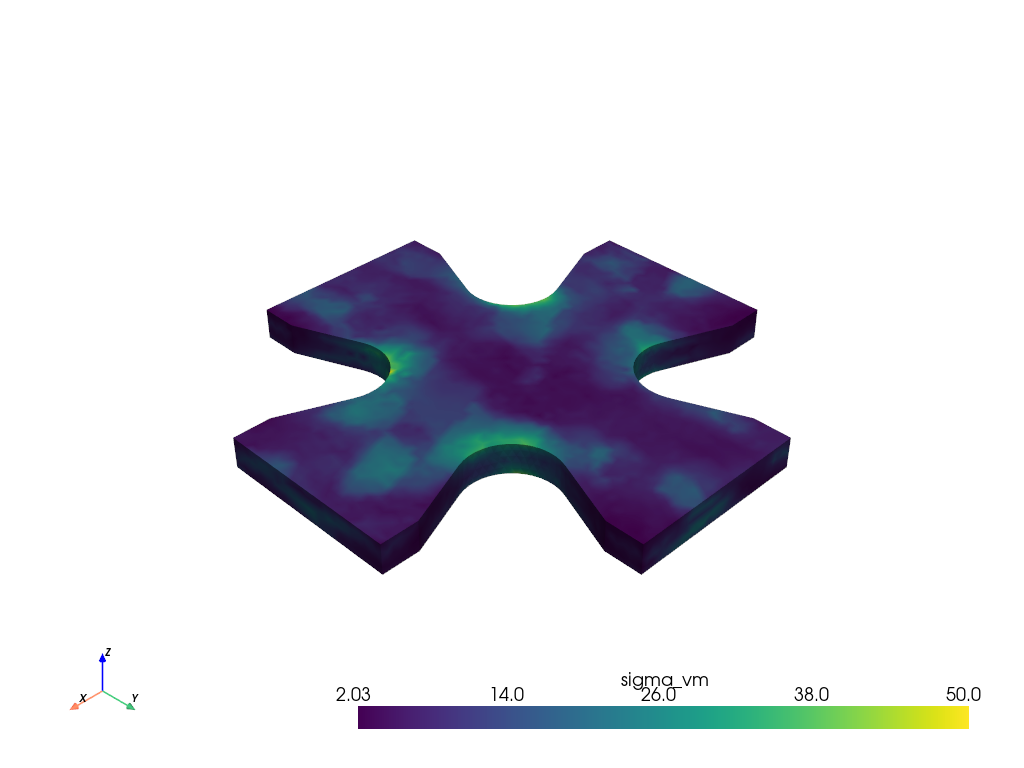

In [12]:
first_sample = samples[0]
vals = df[df['sample_id']==first_sample]['sigma_vm'].values
plot_mesh = mesh_ref.copy()
plot_mesh.point_data['sigma_vm'] = vals
plot_mesh.plot(scalars='sigma_vm', cmap='viridis', show_scalar_bar=True)


## 3D Mesh Visualization

In [19]:
pv.set_jupyter_backend('trame')

sample_to_plot = samples[0]
vals = df[df['sample_id'] == sample_to_plot]['sigma_vm'].values

plot_mesh = mesh_ref.copy()
plot_mesh.point_data['sigma_vm'] = vals

plotter = pv.Plotter(notebook=True)
plotter.add_mesh(plot_mesh, scalars='sigma_vm', cmap='viridis', show_scalar_bar=True)
plotter.add_axes()
plotter.show_grid()
plotter.show()



Widget(value='<iframe src="http://localhost:62755/index.html?ui=P_0x20d0b2d2fd0_1&reconnect=auto" class="pyvis…

### Data Cleaning

In [13]:
print("Any NaNs?", df.isna().any().any())
nan_counts = df.isna().sum()
display(nan_counts[nan_counts>0])

if df.isna().any().any():
    for col in df.columns:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)
    print('[INFO] NaNs filled with medians.')


Any NaNs? False


Series([], dtype: int64)

### Feature Scaling

In [14]:
feature_cols = [c for c in df.columns if c.startswith('E_')] + ['x','y','z']
target_col = 'sigma_vm'

X_all = df[feature_cols].values
y_all = df[target_col].values.reshape(-1,1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

In [15]:
for i,col in enumerate(feature_cols):
    df[f'{col}_s'] = X_scaled[:, i]

print('[INFO] Scaled feature columns added:')
print([f'{c}_s' for c in feature_cols])

[INFO] Scaled feature columns added:
['E_0_s', 'x_s', 'y_s', 'z_s']
